<center>
<h1>INTERIM PROJECT REPORT</h1>
<h1>DIABETES READMISSION PREDICTION</h1>
<h1>(DOMAIN - HEALTHCARE)</h1>
</center>


## DATA DICTIONARY

encounter_id – Unique identifier for each hospital visit.

patient_nbr – Unique identifier for each patient across visits.

race – Patient's race (e.g., Caucasian, African-American).

gender – Patient's gender (Male/Female/Unknown).

age – Age group of the patient in 10-year intervals.

weight – Patient's weight (mostly missing).

admission_type_id – Type of admission (e.g., emergency, elective).

discharge_disposition_id – Where the patient went after discharge (e.g., home, died, rehab).

admission_source_id – Source of admission (e.g., referral, ER, transfer).

time_in_hospital – Number of days the patient stayed in the hospital.

payer_code – Type of insurance used (e.g., Medicare, Medicaid).

medical_specialty – Specialty of the attending physician (e.g., cardiology, internal medicine).

num_lab_procedures – Number of lab tests performed during the stay.

num_procedures – Number of non-lab procedures (e.g., imaging, surgeries).

num_medications – Count of distinct medications administered.

number_outpatient – Number of outpatient visits in the year before admission.

number_emergency – Number of ER visits in the past year.

number_inpatient – Number of previous hospital stays in the past year.

diag_1 – Primary diagnosis ICD-9 code.

diag_2 – Secondary diagnosis ICD-9 code.

diag_3 – Tertiary diagnosis ICD-9 code.

number_diagnoses – Number of distinct ICD diagnoses in the encounter.

max_glu_serum – Max glucose level measured during stay (categorical).

A1Cresult – Most recent A1C test result (long-term glucose control).A1C is a blood test that shows your average blood sugar level over the past 2 to 3 months. >7 Poor sugar control



metformin – Indicates whether metformin was prescribed and if changed.

repaglinide – Indicates repaglinide use.

nateglinide – Indicates nateglinide use.

chlorpropamide – Indicates chlorpropamide use.

glimepiride – Indicates glimepiride use.

acetohexamide – Indicates acetohexamide use.

glipizide – Indicates glipizide use.

glyburide – Indicates glyburide use.

tolbutamide – Indicates tolbutamide use.

pioglitazone – Indicates pioglitazone use.

rosiglitazone – Indicates rosiglitazone use.

acarbose – Indicates acarbose use.

miglitol – Indicates miglitol use.

troglitazone – Indicates troglitazone use.

tolazamide – Indicates tolazamide use.

examide – Indicates examide use (always 'No').

citoglipton – Indicates citoglipton use (always 'No').

insulin – Indicates insulin use and any change in dosage.

glyburide-metformin – Use of combination drug glyburide+metformin.

glipizide-metformin – Use of glipizide+metformin combo drug.

glimepiride-pioglitazone – Use of glimepiride+pioglitazone combo drug.

metformin-rosiglitazone – Use of metformin+rosiglitazone combo drug.

metformin-pioglitazone – Use of metformin+pioglitazone combo drug.

change – Whether any diabetes medication was changed during the visit.

diabetesMed – Whether the patient was prescribed any diabetes medication.

readmitted – Whether the patient was readmitted within 30 days, after 30 days, or not at all.

In [92]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix,classification_report
from sklearn.preprocessing import PowerTransformer,StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import scipy as sp


In [93]:
pip install catboost

In [94]:
df=pd.read_csv('/content/diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [95]:
print("no of rows: ",df.shape[0])
print("no of columns: ",df.shape[1])

no of rows:  101766
no of columns:  50


### FINDING NULL VALUES WHICH ARE NOT NAN AND REPLACING IT WITH NAN

In [96]:
df.replace('?',pd.NA,inplace=True)
df.replace("Unknown/Invalid",pd.NA,inplace=True)
df['discharge_disposition_id'].replace(11,pd.NA,inplace=True)

### STATISTICAL SUMMARY

In [97]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


### DATATYPES OF COLUMNS

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  100124 non-null  object
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [99]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [100]:
print("null values totall in the dataset in percentage: ",df.isnull().sum().sum()*100/df.size)

null values totall in the dataset in percentage:  7.382858715091484


In [101]:
print("null values percentage in each column: ")
df.isnull().sum()*100/len(df)

null values percentage in each column: 


,0
encounter_id,0.000000
patient_nbr,0.000000
race,2.233555
gender,0.002948
age,0.000000
weight,96.858479
admission_type_id,0.000000
discharge_disposition_id,1.613505
admission_source_id,0.000000
time_in_hospital,0.000000


#### DROPPING DUPLICATES AND COLUMNS WITH NULL VALUE PERCENTAGE WITH MORE THAN 40% OR INSIGNIFICANT DATA LIKE IDS,DID NOT DROP COLUMNS WITH CRUCIAL INFORMATION LIKE GLUCOSE CONTENT.

In [102]:
df.drop_duplicates(inplace=True)
df.drop(['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)
df['race'] = df['race'].fillna('Unknown')

In [103]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [104]:
print(df[['number_outpatient', 'number_emergency', 'number_inpatient']].corr())


                   number_outpatient  number_emergency  number_inpatient
number_outpatient           1.000000          0.091459          0.107338
number_emergency            0.091459          1.000000          0.266559
number_inpatient            0.107338          0.266559          1.000000


### NUMERIC AND CATEGORIC COLUMNS

In [105]:
num=df.select_dtypes(include=['int64','float64']).columns
cat=df.select_dtypes(include=['object']).columns
print(num)
print(cat)

Index(['admission_type_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'service_utilization'],
      dtype='object')
Index(['race', 'gender', 'age', 'discharge_disposition_id', 'diag_1', 'diag_2',
       'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')


## MAPPING/BASIC ENCODING

ADMISSION_TYPE_ID

1: Emergency

2: Urgent

3: Elective

4: Newborn

5: Not Available

6: NULL

7: Trauma Center

8: Not Mapped

In [106]:
df["admission_type_id"] = df["admission_type_id"].replace({2: 1, 7: 1, 6: 5, 8: 5}) #1 is top priority,5 is null,3 is elective,4 is newborn
df["admission_type_id"].value_counts(normalize=True)*100
#df = df[df['admission_type_id'] != 5]


,proportion
admission_type_id,
1,71.233025
3,18.541556
5,10.215593
4,0.009826


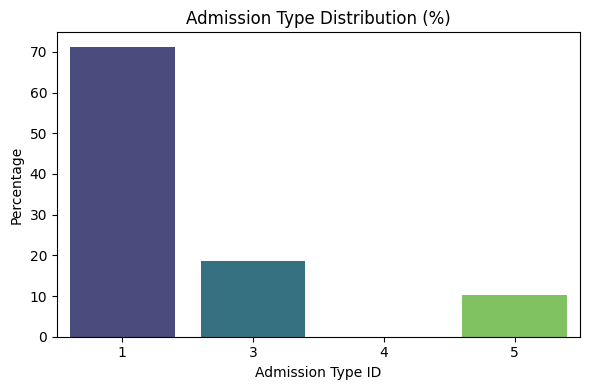

In [107]:
admission_perc = df['admission_type_id'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
sns.barplot(x=admission_perc.index, y=admission_perc.values, palette='viridis')
plt.title('Admission Type Distribution (%)')
plt.xlabel('Admission Type ID')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

Most patients' admission were because of urgent treatment needs.

discharge_disposition_id

1: Discharged to home

2: Discharged/transferred to another short term hospital

3: Discharged/transferred to SNF

4: Discharged/transferred to ICF

5: Discharged/transferred to another type of inpatient care institution

6: Discharged/transferred to home with home health service

7: Left AMA

8: Discharged/transferred to home under care of Home IV provider

9: Admitted as an inpatient to this hospital

10: Neonate discharged to another hospital for neonatal aftercare

11: Expired

12: Still patient or expected to return for outpatient services

13: Hospice / home

14: Hospice / medical facility

15: Discharged/transferred within this institution to Medicare approved swing bed

16: Discharged/transferred/referred another institution for outpatient services

17: Discharged/transferred/referred to this institution for outpatient services

18: NULL

19: Expired at home. Medicaid only, hospice.

20: Expired in a medical facility. Medicaid only, hospice.

21: Expired, place unknown. Medicaid only, hospice.

22: Discharged/transferred to another rehab fac including rehab units of a hospital.

23: Discharged/transferred to a long term care hospital.

24: Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.

25: Not Mapped

26: Unknown/Invalid

27: Discharged/transferred to a federal health care facility.

28: Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital

29: Discharged/transferred to a Critical Access Hospital (CAH).

30: Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere

In [108]:
df["discharge_disposition_id"] = df["discharge_disposition_id"].replace({
    1: 1, 6: 1, 8: 1, 13: 1,  # home
    2: 2, 3: 2, 4: 2, 5: 2, 14: 2, 22: 2, 23: 2, 24: 2, 30: 2,  # other_hospital
    12: 3, 15: 3, 16: 3, 17: 3, 27: 3, 28: 3, 29: 3,  # not_final
    11: 4, 19: 4, 20: 4, 21: 4,  # expired
    np.nan:5,18: 5, 25: 5, 26: 5,  # unknown
    7: 6, 9: 6, 10: 6  # other
})
df["discharge_disposition_id"].value_counts(normalize=True)*100

,proportion
discharge_disposition_id,
1,72.365034
2,20.543207
5,6.212291
6,0.638720
3,0.230922
4,0.009826


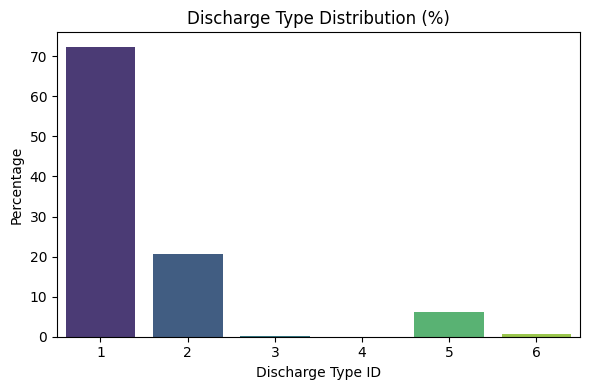

In [109]:
dis_perc = df['discharge_disposition_id'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
sns.barplot(x=dis_perc.index, y=dis_perc.values, palette='viridis')
plt.title('Discharge Type Distribution (%)')
plt.xlabel('Discharge Type ID')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

Most of them were discharged to home.

ADMISSION_SOURCE_ID

1: Physician Referral

2: Clinic Referral

3: HMO Referral

4: Transfer from a hospital

5: Transfer from a Skilled Nursing Facility (SNF)

6: Transfer from another health care facility

7: Emergency Room

8: Court/Law Enforcement

9: Not Available

10: Transfer from critical access hospital

11: Normal Delivery

12: Premature Delivery

13: Sick Baby

14: Extramural Birth

15: Not Available

17: NULL

18: Transfer From Another Home Health Agency

19: Readmission to Same Home Health Agency

20: Not Mapped

21: Unknown/Invalid

22: Transfer from hospital inpt/same fac reslt in a sep claim

23: Born inside this hospital

24: Born outside this hospital

25: Transfer from Ambulatory Surgery Center

26: Transfer from Hospice

In [110]:
df["admission_source_id"] = df["admission_source_id"].replace({
    1: 1, 2: 1, 3: 1,  # referral
    4: 2, 5: 2, 6: 2, 10: 2, 18: 2, 19: 2, 22: 2, 25: 2, 26: 2,  # transfer
    7: 3,  # emergency
    11: 4, 12: 4, 13: 4, 14: 4, 23: 4, 24: 4,  # birth/delivery
    9: 5, 15: 5, 17: 5, 20: 5, 21: 5,  # unknown
    8: 6  # legal/other
})
df['admission_source_id'].value_counts(normalize=True)*100

,proportion
admission_source_id,
3,56.496276
1,30.320539
5,6.944363
2,6.218187
6,0.015722
4,0.004913


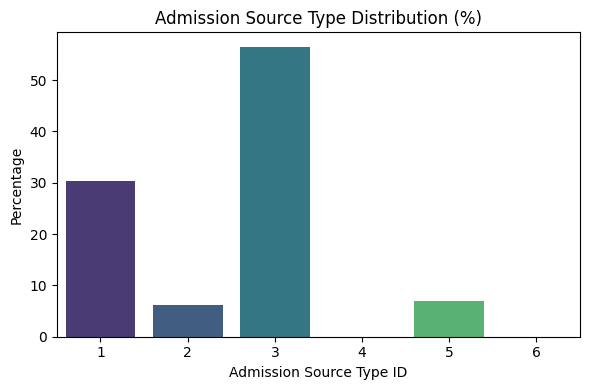

In [111]:
admission_source_perc = df['admission_source_id'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
sns.barplot(x=admission_source_perc.index, y=admission_source_perc.values, palette='viridis')
plt.title('Admission Source Type Distribution (%)')
plt.xlabel('Admission Source Type ID')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

More than half patients admit to hospitals through referrals or because of emergencies

READMITTED
No readmission;
A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate);
A readmission in more than 30 days (this one is not so good as well the last one, however, the reason can be the state of the patient.


In [112]:
# Encode categorical variables
d_cat = {
        "change": {"Ch": 1, "No": 0},  #
        "gender": {"Male": 1, "Female": 0},
        "diabetesMed": {"Yes": 1, "No": 0},
        "A1Cresult": {">7": 1, ">8": 1, "Norm": 0, np.nan: -99},
        "max_glu_serum": {">200": 1, ">300": 1, "Norm": 0, np.nan: -99},
        "readmitted": {">30": 0, "<30": 1, "NO": 0},
    }

# Perform mapping
for k, v in d_cat.items():
    df[k] = df[k].map(v)

# Optional: Fill unmapped values (like missing data) if needed
df['gender'] = df['gender'].fillna(-99)
df['A1Cresult'] = df['A1Cresult'].fillna(-99)
df['max_glu_serum'] = df['max_glu_serum'].fillna(-99)


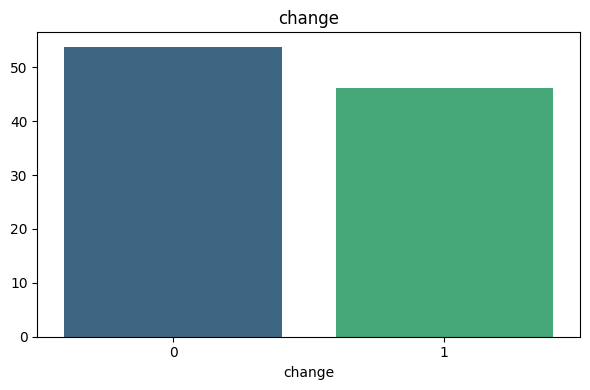

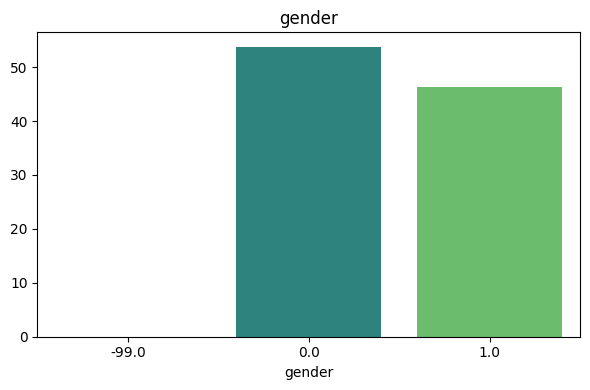

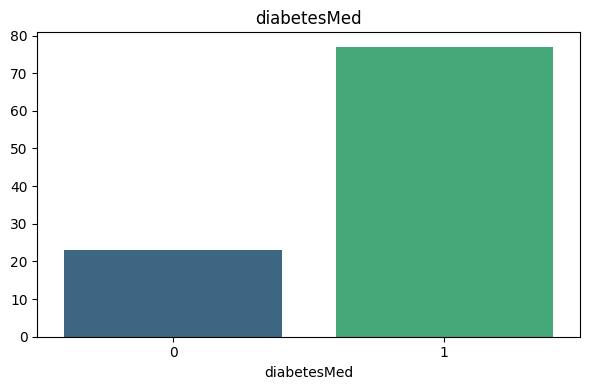

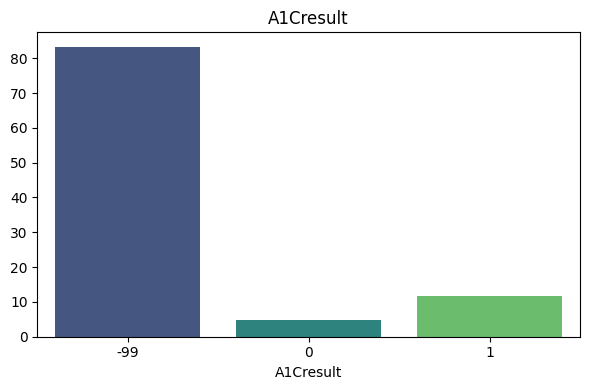

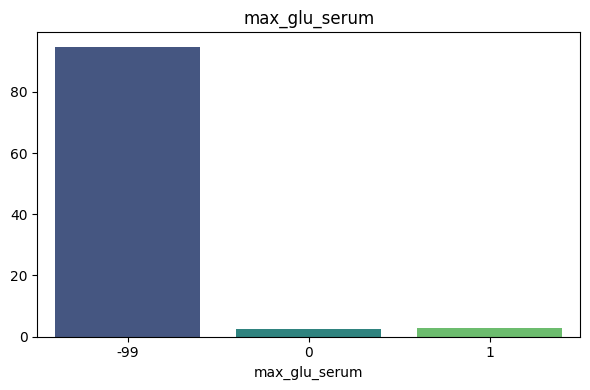

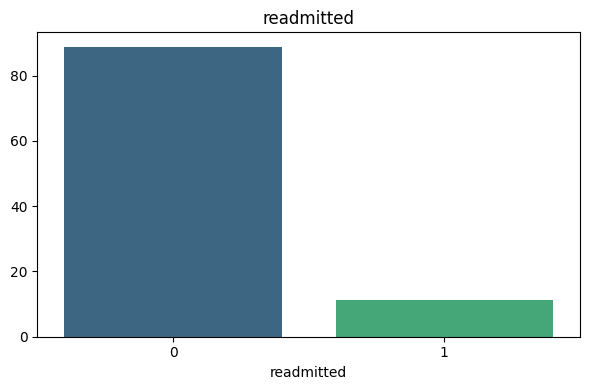

In [113]:
for i in d_cat:
    bc = df[i].value_counts(normalize=True) * 100
    plt.figure(figsize=(6,4))
    sns.barplot(x=bc.index, y=bc.values, palette='viridis')
    plt.title(i)
    plt.tight_layout()
    plt.show()

More female have diabetes
Patients are mostly prescribed medications
Patients dont return within 30 days for most cases

### LOGICAL IMPUTATION USED FOR DIAG_ SINCE THE VALUE HAS A CODE FOR DIAGNOSIS

In [114]:
df['diag_1'] = df['diag_1'].astype(str)
df['diag_2'] = df['diag_2'].astype(str)
df['diag_3'] = df['diag_3'].astype(str)
df = df[(df['diag_1'].notna()) & (df['diag_2'].notna()) & (df['diag_3'].notna())]

category_mapping = {
    'Other': 0,
    'Circulatory': 1,
    'Respiratory': 2,
    'Digestive': 3,
    'Diabetes': 4,
    'Injury': 5,
    'Musculoskeletal': 6,
    'Genitourinary': 7,
    'Neoplasms': 8
}

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = np.where(df[col].str.startswith(('V', 'E')), '-1', df[col])
    numeric_col = pd.to_numeric(df[col], errors='coerce').fillna(-1)
    df[col] = np.where((numeric_col >= 390) & (numeric_col <= 459) | (numeric_col == 785), 'Circulatory', df[col])
    df[col] = np.where((numeric_col >= 460) & (numeric_col <= 519) | (numeric_col == 786), 'Respiratory', df[col])
    df[col] = np.where((numeric_col >= 520) & (numeric_col <= 579) | (numeric_col == 787), 'Digestive', df[col])
    df[col] = np.where(numeric_col == 250, 'Diabetes', df[col])
    df[col] = np.where((numeric_col >= 800) & (numeric_col <= 999), 'Injury', df[col])
    df[col] = np.where((numeric_col >= 710) & (numeric_col <= 739), 'Musculoskeletal', df[col])
    df[col] = np.where((numeric_col >= 580) & (numeric_col <= 629), 'Genitourinary', df[col])
    df[col] = np.where((numeric_col >= 140) & (numeric_col <= 239), 'Neoplasms', df[col])
    df[col] = np.where(~df[col].isin(category_mapping.keys()), 'Other', df[col])
    df[col] = df[col].map(category_mapping).astype('object')


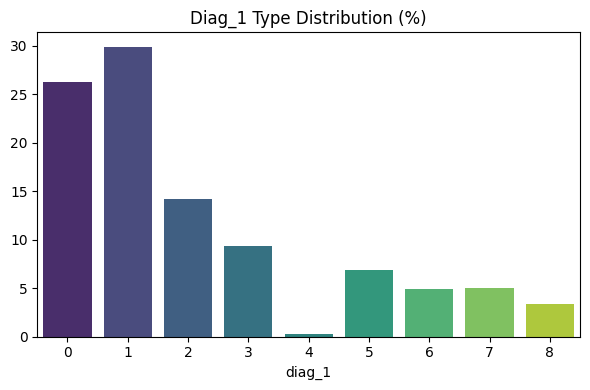

In [115]:
dg = df['diag_1'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
sns.barplot(x=dg.index, y=dg.values, palette='viridis')
plt.title('Diag_1 Type Distribution (%)')
plt.tight_layout()
plt.show()

In primary diagnosis,patients get diagnozied with cardiovascular or blood circulatory issues.

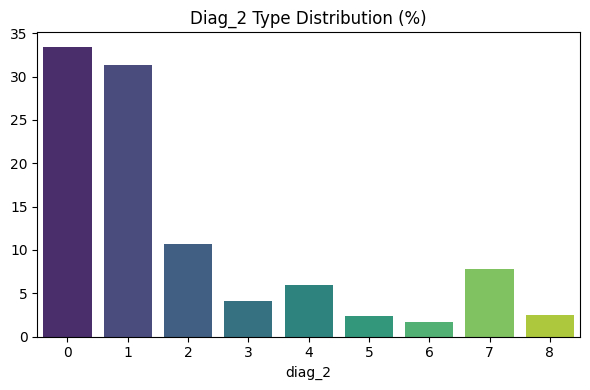

In [116]:
dg2 = df['diag_2'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
sns.barplot(x=dg2.index, y=dg2.values, palette='viridis')
plt.title('Diag_2 Type Distribution (%)')
plt.tight_layout()
plt.show()

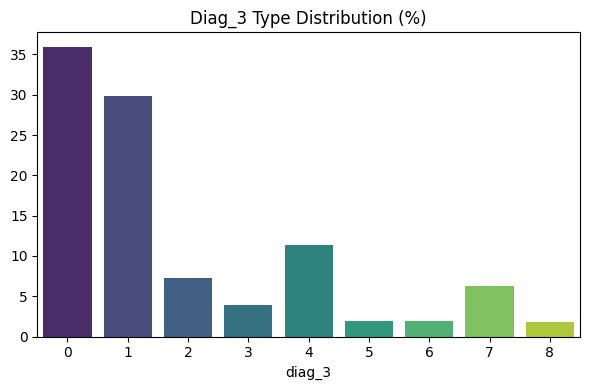

In [117]:
dg3= df['diag_3'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
sns.barplot(x=dg3.index, y=dg3.values, palette='viridis')
plt.title('Diag_3 Type Distribution (%)')
plt.tight_layout()
plt.show()

We can infer that the diabetes detection(4) has happened in the later stages.

In [118]:
age_mapping = {
    '[0-10)': 1,
    '[10-20)': 2,
    '[20-30)': 3,
    '[30-40)': 4,
    '[40-50)': 5,
    '[50-60)': 6,
    '[60-70)': 7,
    '[70-80)': 8,
    '[80-90)': 9,
    '[90-100)': 10
}

df['age'] = df['age'].replace(age_mapping)
df['age'].value_counts(normalize=True)*100

,proportion
age,
8,25.615628
7,22.092840
6,16.956547
9,16.898571
5,9.516931
4,3.709490
10,2.744532
3,1.628245
2,0.679009


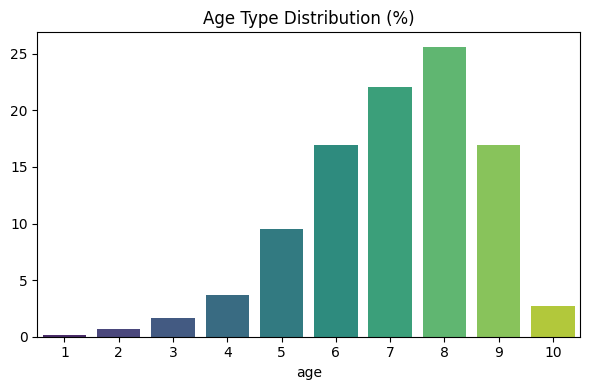

In [119]:
ag= df['age'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
sns.barplot(x=ag.index, y=ag.values, palette='viridis')
plt.title('Age Type Distribution (%)')
plt.tight_layout()
plt.show()

Most admissions for diabetes are aged from 70 to 80 years old.

In [120]:
cat=['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id','max_glu_serum','A1Cresult','change','diabetesMed']
for i in cat:
    df[i]=df[i].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  object
 4   discharge_disposition_id  101766 non-null  object
 5   admission_source_id       101766 non-null  object
 6   time_in_hospital          101766 non-null  int64 
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_outpatient         101766 non-null  int64 
 11  number_emergency          101766 non-null  int64 
 12  number_inpatient          101766 non-null  int64 
 13  diag_1                    101766 non-null  object
 14  diag

### BIVARIATE ANALYSIS

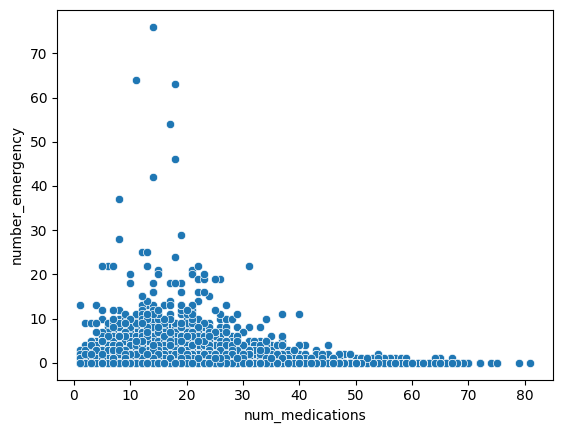

In [121]:
#NUM VS NUM
sns.scatterplot(data=df, x='num_medications', y='number_emergency')
plt.show()

In [122]:
df['num_medications'].corr(df['number_emergency'])

np.float64(0.013179927892209937)

Number of emergency cases have no relation with number of medications they take.

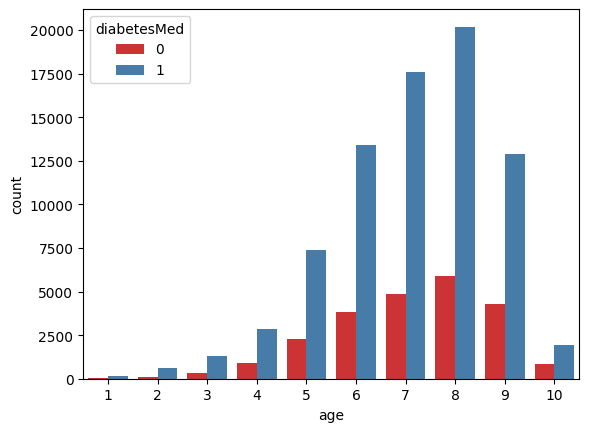

In [123]:
#CAT VS CAT
sns.countplot(data=df, hue='diabetesMed', x='age',palette='Set1')
plt.show()


All age groups are getting prescribed diabetes medicines

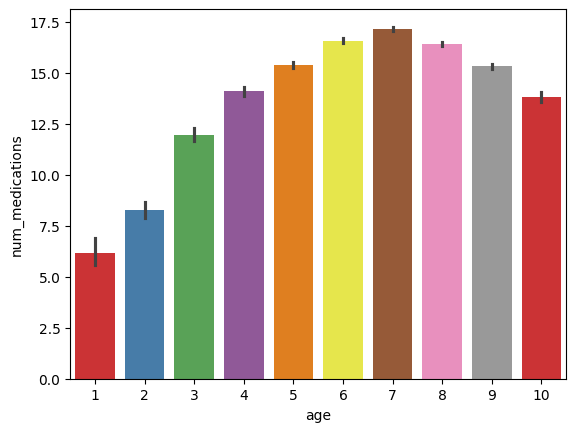

In [124]:
#CAT VS NUM
sns.barplot(data=df,x='age', y='num_medications',palette='Set1')
plt.show()


Age 70 to 80 are prescribed most amount of medicines

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  object
 4   discharge_disposition_id  101766 non-null  object
 5   admission_source_id       101766 non-null  object
 6   time_in_hospital          101766 non-null  int64 
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_outpatient         101766 non-null  int64 
 11  number_emergency          101766 non-null  int64 
 12  number_inpatient          101766 non-null  int64 
 13  diag_1                    101766 non-null  object
 14  diag

STATISTICAL TESTS TO UNDERSTAND DATA


In [ ]:
#cat vs num
from scipy.stats import ttest_ind
#ho: no difference bw mean no of lab procedures between readmitted and non readmitted u1=u2
#ha:there is difference u1!=u2
group1 = df[df['readmitted'] == 0]['num_lab_procedures']
group2 = df[df['readmitted'] == 1]['num_lab_procedures']
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

print("T-statistic:", round(t_stat, 4))
print("P-value:", round(p_value, 4))
#T-statistic: -5.4073
P-value: 0.0
#Since p<0.05 rejecting null hypothesis,there is a significant difference in the average number of lab procedures between patients who were readmitted and those who were not.

In [ ]:
#cat vs cat
import pandas as pd
from scipy.stats import chi2_contingency
#ho: gender and change are independent
#ha: they are dependent
contingency_table = pd.crosstab(df['gender'], df['change'])
chi2, p,_,_ = chi2_contingency(contingency_table)
print("P-value:", round(p, 4))
P-value: 0.0039
Since p<0.05,rejecting ho,gender and change depend on each other.
#num vs num
from scipy.stats import pearsonr
x = df['time_in_hospital']
y = df['num_lab_procedures']
_, p = pearsonr(x, y)
print("P-value:", round(p, 4))
#P-value: 0.0
#Since p<0.05,rejecting ho,there is a correlation between time in hospital and number of procedures.

## OUTLIER REMOVAL AND STANDARD SCALING

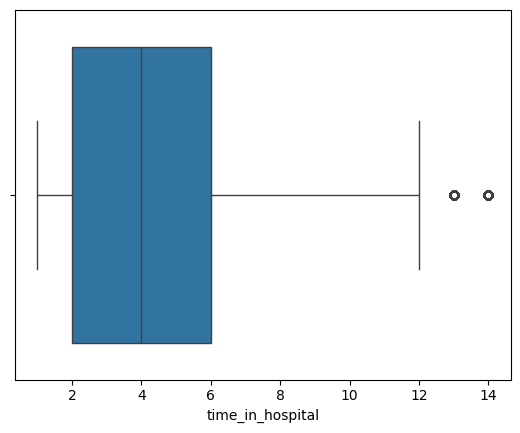

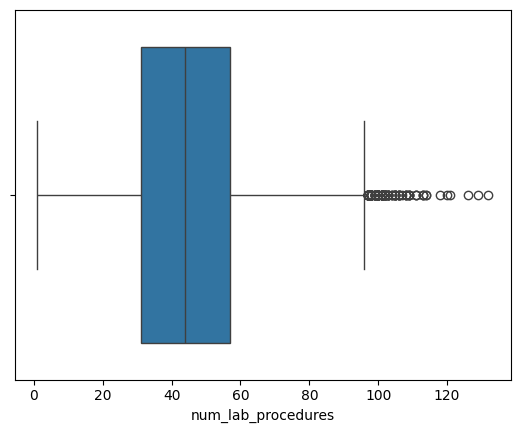

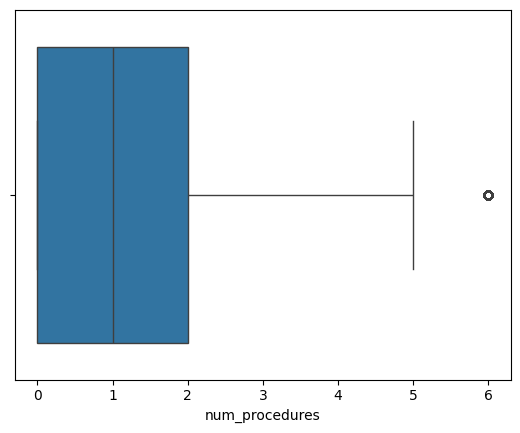

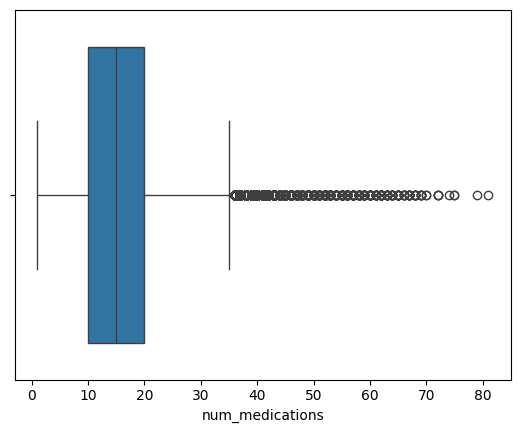

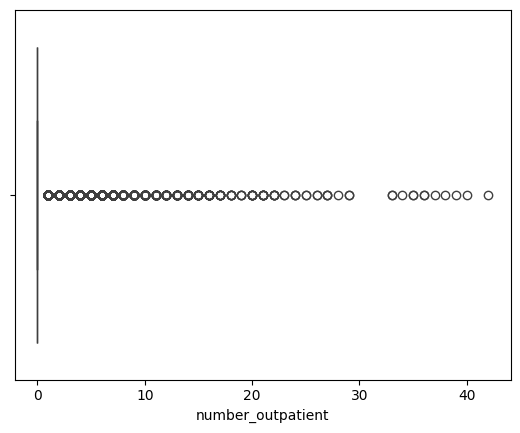

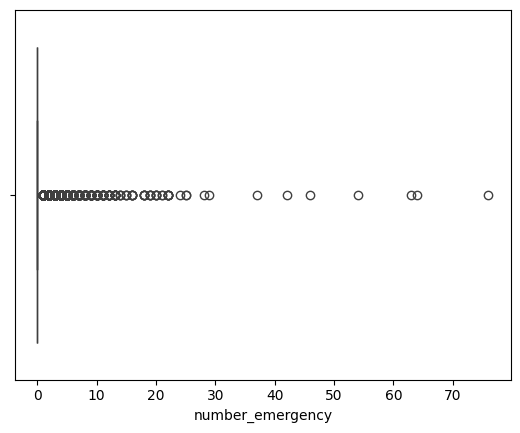

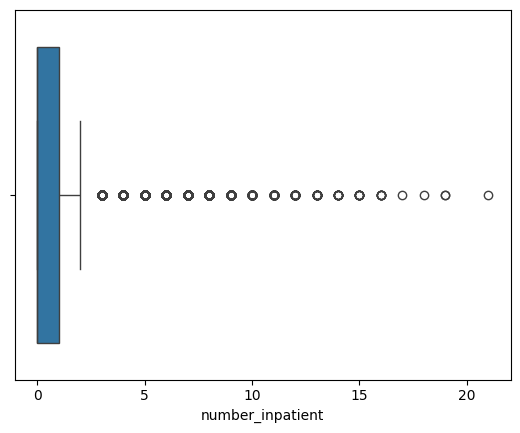

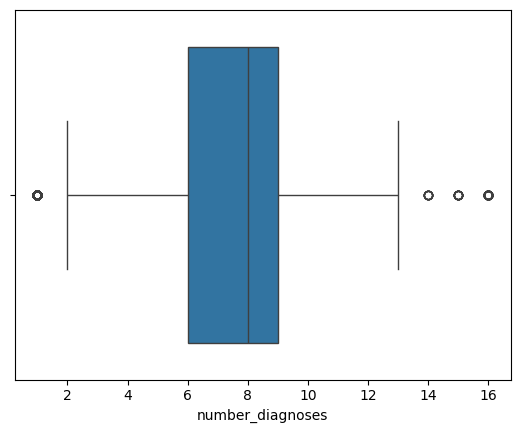

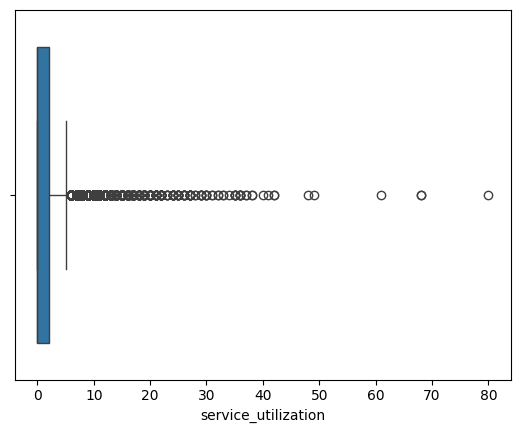

In [126]:
numerics = df.select_dtypes(include=np.number).columns.tolist()
numerics = [col for col in numerics if col != 'readmitted']
for i in numerics:
    sns.boxplot(data=df,x=df[i])
    plt.show()

In [127]:
scaler = StandardScaler()
for col in numerics:
    df[col] = df[col].astype(float)
df[numerics] = scaler.fit_transform(df[numerics])
# Removing outliers using IQR
Q1 = df[numerics].quantile(0.25)
Q3 = df[numerics].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[numerics] < (Q1 - 1.5 * IQR)) | (df[numerics] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [128]:
for i in numerics:
    print(i,    df[i].skew())

time_in_hospital 0.9880091278323129
num_lab_procedures -0.2965573631949143
num_procedures 1.1862153403148
num_medications 0.5719727063736221
number_outpatient 0.0
number_emergency 0.0
number_inpatient 1.707993022953503
number_diagnoses -0.7218209229574094
service_utilization 1.7079930229535023


In [129]:

# pt=PowerTransformer(method='yeo-johnson')
# df2['time_in_hospital'] = np.log1p(df2['time_in_hospital'])
# df2['num_medications'] = np.log1p(df2['num_medications'])
# df2['number_diagnoses'] = pt.fit_transform(df2[['number_diagnoses']])
# for i in numerics:
#     print(i,    df2[i].skew())

In [130]:
for i in numerics:
    print(i,    df[i].kurt())

time_in_hospital 0.4444148747294294
num_lab_procedures -0.2564623019657981
num_procedures 0.5147490046263594
num_medications 0.01644998770240047
number_outpatient 0.0
number_emergency 0.0
number_inpatient 1.8014961638458753
number_diagnoses -0.6828090643528251
service_utilization 1.8014961638458726


Ignoring number_inpatient since for tree based models,it handles natively in the model.

## DUMMY ENCODING

In [131]:
dummy_cols = [
    "gender","admission_type_id","discharge_disposition_id",
    "admission_source_id","max_glu_serum","A1Cresult","race","metformin","repaglinide","nateglinide","chlorpropamide","glimepiride",
    "acetohexamide","glipizide","glyburide","tolbutamide","pioglitazone",
    "rosiglitazone","acarbose","miglitol","troglitazone","tolazamide","examide","citoglipton",
    "insulin","glyburide-metformin","glipizide-metformin",
    "glimepiride-pioglitazone","metformin-rosiglitazone",
    "metformin-pioglitazone","change","diabetesMed"]
df_encoded = pd.get_dummies(df, columns=dummy_cols, drop_first=True)
df_encoded.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_1,diabetesMed_1
1,2,-0.467653,0.808384,-0.785398,0.243390,-0.291461,-0.21262,-0.503276,0,0,...,True,True,False,False,False,False,False,False,True,True
3,4,-0.802651,0.045967,-0.199162,-0.002688,-0.291461,-0.21262,-0.503276,0,0,...,True,True,False,False,False,False,False,False,True,True
4,5,-1.137649,0.401761,-0.785398,-0.986997,-0.291461,-0.21262,-0.503276,8,8,...,False,True,False,False,False,False,False,False,True,True
6,7,-0.132655,1.367490,-0.199162,0.612506,-0.291461,-0.21262,-0.503276,1,1,...,False,True,False,False,False,False,False,False,True,True
7,8,0.202343,1.519973,-0.785398,-0.494842,-0.291461,-0.21262,-0.503276,1,2,...,False,True,False,False,False,False,False,False,False,True


In [132]:
df_encoded.iloc[:,51:61].head() # check middle few rows


,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No
1,False,False,True,False,False,True,False,False,False,True
3,False,False,True,False,False,True,False,False,False,True
4,False,False,False,True,False,True,False,False,False,True
6,True,False,True,False,False,True,False,False,False,True
7,False,False,True,False,False,False,True,False,False,True


In [133]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67270 entries, 1 to 101765
Data columns (total 85 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              67270 non-null  object 
 1   time_in_hospital                 67270 non-null  float64
 2   num_lab_procedures               67270 non-null  float64
 3   num_procedures                   67270 non-null  float64
 4   num_medications                  67270 non-null  float64
 5   number_outpatient                67270 non-null  float64
 6   number_emergency                 67270 non-null  float64
 7   number_inpatient                 67270 non-null  float64
 8   diag_1                           67270 non-null  object 
 9   diag_2                           67270 non-null  object 
 10  diag_3                           67270 non-null  object 
 11  number_diagnoses                 67270 non-null  float64
 12  readmitted            

In [134]:
df_encoded.shape

(67270, 85)

### CORRELATION-HEATMAP

In [135]:
df_corr = df_encoded.corr(numeric_only=True)
top_corr = df_corr['readmitted'].drop('readmitted').abs().sort_values(ascending=False).head(10)
print("Top 5 features most correlated with readmitted ")
print(top_corr)


Top 5 features most correlated with readmitted 
discharge_disposition_id_2    0.095423
number_inpatient              0.093189
service_utilization           0.093189
time_in_hospital              0.052939
number_diagnoses              0.046069
discharge_disposition_id_3    0.040639
num_medications               0.040556
insulin_No                    0.025176
diabetesMed_1                 0.024786
num_lab_procedures            0.020494
Name: readmitted, dtype: float64


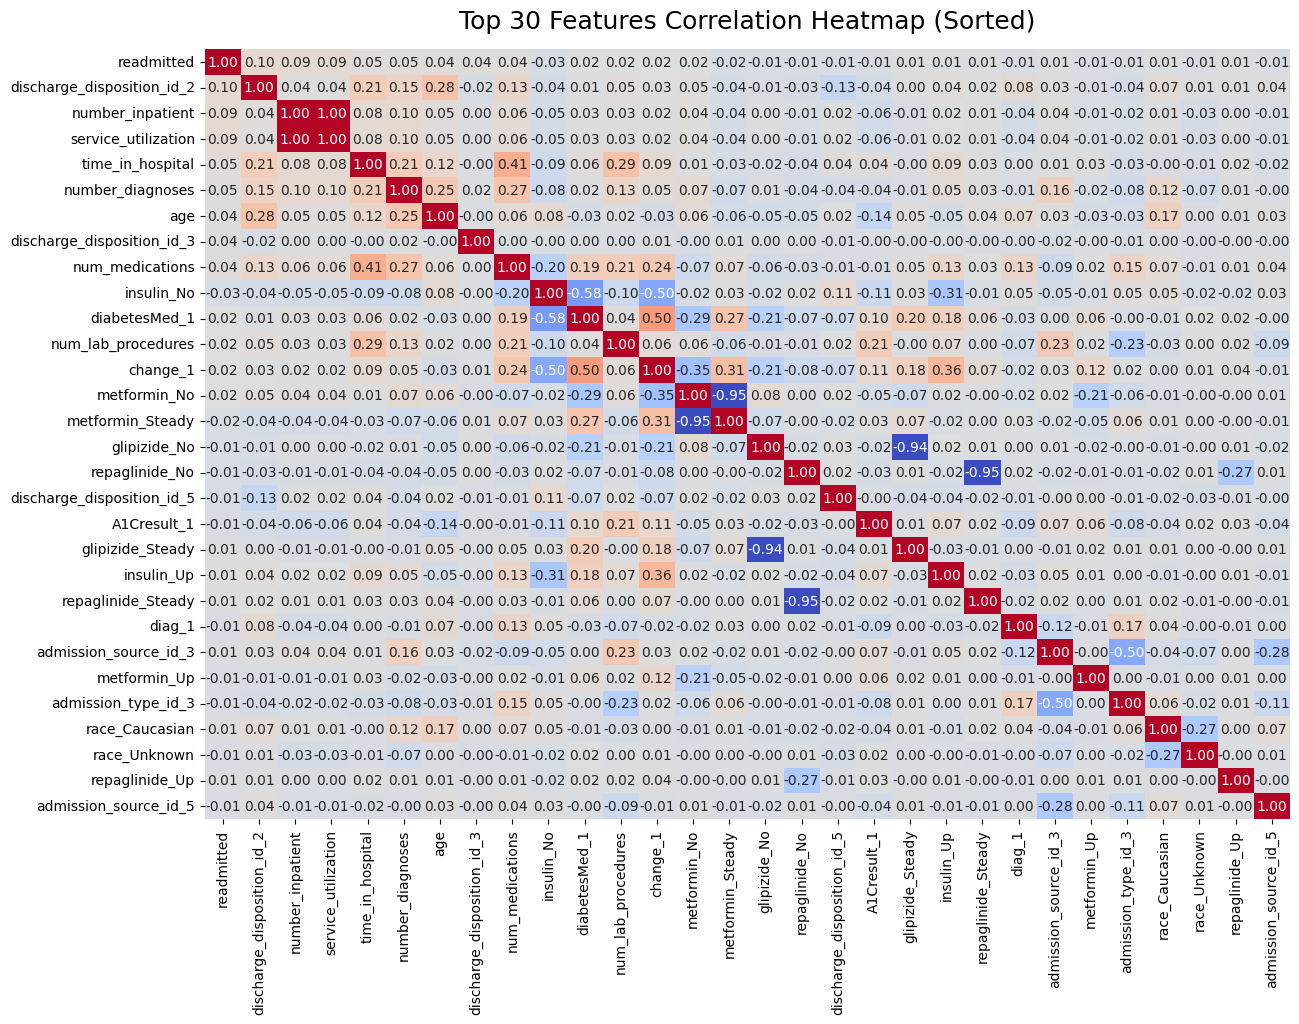

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation with target
target_col = 'readmitted'
corr_with_target = df_encoded.corr()[target_col].abs().sort_values(ascending=False)

# Get top 30 features
top_30_features = corr_with_target.head(30).index

# Sort correlation matrix for better grouping
corr_matrix = df_encoded[top_30_features].corr()
sorted_features = corr_matrix[target_col].abs().sort_values(ascending=False).index
sorted_corr_matrix = corr_matrix.loc[sorted_features, sorted_features]

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(sorted_corr_matrix, annot=True, cbar=False, cmap='coolwarm', fmt=".2f")
plt.title("Top 30 Features Correlation Heatmap (Sorted)", fontsize=18, pad=15)
plt.show()


### BALANCING TARGET AND TRAIN-TEST SPLIT

In [137]:
X=df_encoded.drop('readmitted',axis=1)
y = df_encoded["readmitted"]
maj = X[y == 0]
min_ = X[y == 1]
# Duplicate minority class by sampling with replacement until it matches majority size
min_up = resample(min_, replace=True, n_samples=len(maj), random_state=20)
X_bal = pd.concat([maj, min_up])
y_bal = pd.Series([0]*len(maj) + [1]*len(min_up))
xtrain, xtest, ytrain, ytest = train_test_split(X_bal, y_bal, test_size=0.2, random_state=0)


In [138]:
df_encoded.shape

(67270, 85)

In [139]:
print("Distribution of y_test:")
print(ytest.value_counts())

print("\nDistribution of y_train:")
print(ytrain.value_counts())

Distribution of y_test:
1    12182
0    12146
Name: count, dtype: int64

Distribution of y_train:
0    48673
1    48637
Name: count, dtype: int64


In [140]:
print("Train size:", len(xtrain))
print("Test size:", len(xtest))
print("Total rows:", len(xtrain) + len(xtest))


Train size: 97310
Test size: 24328
Total rows: 121638


### FITTING,PREDICTION AND FEATURE IMPORTANCE

In [141]:
from sklearn.preprocessing import LabelEncoder

for col in ['age', 'diag_1', 'diag_2', 'diag_3']:
    le = LabelEncoder()
    xtrain[col] = le.fit_transform(xtrain[col].astype(str))
    xtest[col] = le.transform(xtest[col].astype(str))


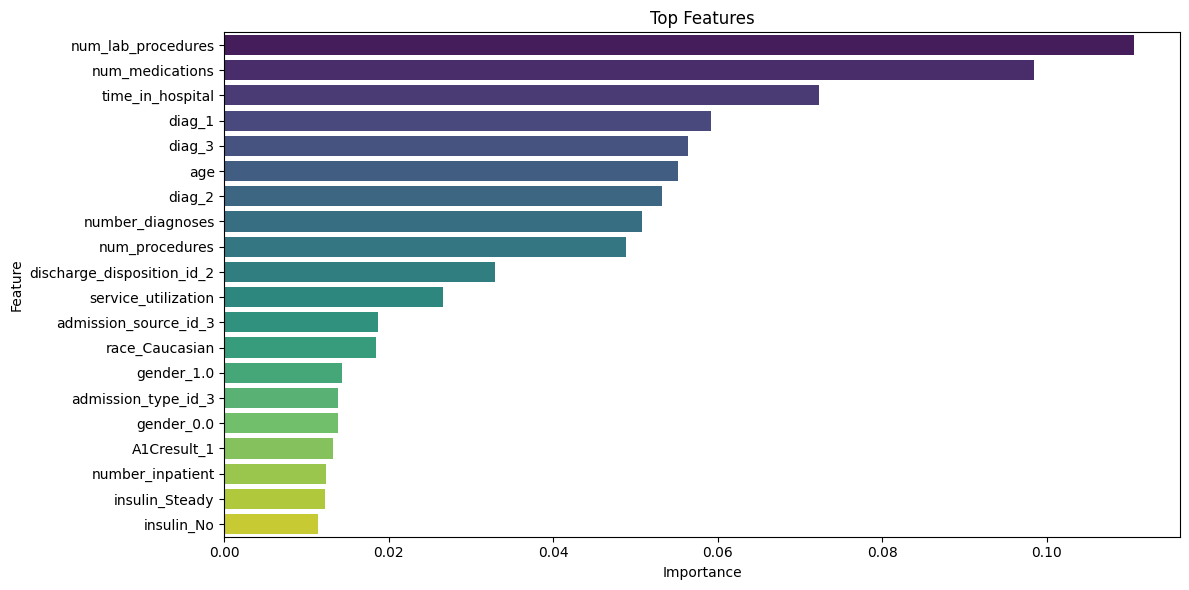

In [142]:
rf = RandomForestClassifier(n_estimators=10, max_depth=25, criterion="gini", min_samples_split=10)
#rf = RandomForestClassifier(n_estimators=50,criterion="gini", min_samples_split=2)
rf.fit(xtrain, ytrain)
y_pred = rf.predict(xtest)
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')
plt.title('Top Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### EVALUATION

In [143]:
y_train_pred = rf.predict(xtrain)
train_accuracy = accuracy_score(ytrain, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
y_test_pred = rf.predict(xtest)
test_accuracy = accuracy_score(ytest, y_test_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Accuracy:  {accuracy_score(ytest, y_pred):.2f}")
print(f"Precision: {precision_score(ytest, y_pred):.2f}")
print(f"Recall:    {recall_score(ytest, y_pred):.2f}")

Training Accuracy: 0.9828
Testing Accuracy: 0.9506
Accuracy:  0.95
Precision: 0.93
Recall:    0.98


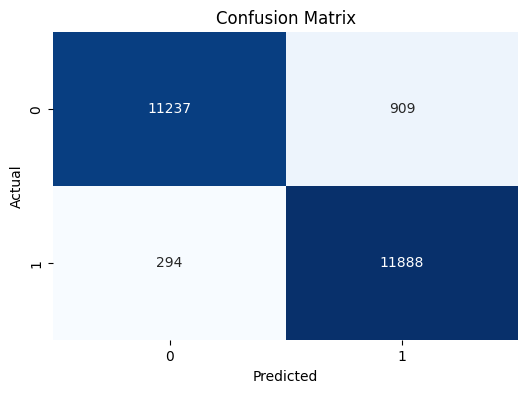

In [176]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(ytest, y_test_pred)  # Note: true labels first, then predictions

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [145]:
print("Confusion matrix total:", np.sum(cm))


Confusion matrix total: 24328


In [146]:
print(classification_report(y_test_pred, ytest))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11531
           1       0.98      0.93      0.95     12797

    accuracy                           0.95     24328
   macro avg       0.95      0.95      0.95     24328
weighted avg       0.95      0.95      0.95     24328



In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Define model
rf = RandomForestClassifier(
    n_estimators=10,
    max_depth=25,
    criterion="gini",
    min_samples_split=10,
    random_state=42
)

# Define cross-validation strategy (StratifiedKFold keeps class balance)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores for each fold
scores = cross_val_score(rf, xtrain, ytrain, cv=cv, scoring='accuracy')

print(f"Cross-validation scores: {scores}")
print(f"Mean CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Cross-validation scores: [0.93859829 0.92929812 0.92729421 0.93150755 0.93803309]
Mean CV Accuracy: 0.9329 ± 0.0046


In [148]:
from sklearn.model_selection import cross_validate

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

cv_results = cross_validate(rf, xtrain, ytrain, cv=cv, scoring=scoring)

print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Mean Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Mean Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Mean F1: {np.mean(cv_results['test_f1']):.4f}")


Mean Accuracy: 0.9329
Mean Precision: 0.9109
Mean Recall: 0.9597
Mean F1: 0.9347


In [149]:
from catboost import CatBoostClassifier
cat_features = ['age', 'diag_1', 'diag_2', 'diag_3']
cat = CatBoostClassifier(cat_features=cat_features, iterations=100, random_seed=42)

cat.fit(xtrain, ytrain)


Learning rate set to 0.5
0:	learn: 0.6729676	total: 117ms	remaining: 11.6s
1:	learn: 0.6655387	total: 227ms	remaining: 11.1s
2:	learn: 0.6618063	total: 380ms	remaining: 12.3s
3:	learn: 0.6589912	total: 478ms	remaining: 11.5s
4:	learn: 0.6565079	total: 536ms	remaining: 10.2s
5:	learn: 0.6540714	total: 601ms	remaining: 9.41s
6:	learn: 0.6525172	total: 667ms	remaining: 8.87s
7:	learn: 0.6511739	total: 745ms	remaining: 8.56s
8:	learn: 0.6500980	total: 818ms	remaining: 8.27s
9:	learn: 0.6482331	total: 890ms	remaining: 8.01s
10:	learn: 0.6471465	total: 968ms	remaining: 7.83s
11:	learn: 0.6458808	total: 1.03s	remaining: 7.59s
12:	learn: 0.6444254	total: 1.1s	remaining: 7.35s
13:	learn: 0.6437957	total: 1.16s	remaining: 7.12s
14:	learn: 0.6421603	total: 1.23s	remaining: 6.94s
15:	learn: 0.6406949	total: 1.29s	remaining: 6.76s
16:	learn: 0.6399981	total: 1.35s	remaining: 6.61s
17:	learn: 0.6392423	total: 1.42s	remaining: 6.45s
18:	learn: 0.6385190	total: 1.49s	remaining: 6.34s
19:	learn: 0.6373

In [150]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix,precision_score

score_card = pd.DataFrame(columns=[
    'Model Name', 'Train Accuracy', 'Test Accuracy', 'f1-weighted', 'Recall', 'ROC AUC',
    'FP %', 'FN %'
])

def update_score_card(model_name, model, xtrain, xtest, ytrain, ytest):
    y_pred_train = model.predict(xtrain)
    y_pred_test = model.predict(xtest)

    train_acc = accuracy_score(ytrain, y_pred_train)
    test_acc = accuracy_score(ytest, y_pred_test)
    rec = recall_score(ytest, y_pred_test)
    f1_sc = f1_score(ytest, y_pred_test, average='weighted')
    pr=precision_score(ytest, y_pred_test)
    # ROC AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(xtest)[:, 1]
        roc_auc = roc_auc_score(ytest, y_prob)
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(xtest)
        roc_auc = roc_auc_score(ytest, y_prob)
    else:
        roc_auc = None

    # Confusion matrix
    cm = confusion_matrix(ytest, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    fp_pct = (fp / total) * 100
    fn_pct = (fn / total) * 100

    new_row = pd.DataFrame({
        'Model Name': [model_name],
        'Train Accuracy': [train_acc],
        'Test Accuracy': [test_acc],
        'f1-weighted': [f1_sc],
        'Recall': [rec],
        'Precision':[pr],
        'ROC AUC': [roc_auc],
        'FP %': [fp_pct],
        'FN %': [fn_pct]
    })

    global score_card
    score_card = pd.concat([score_card, new_row], ignore_index=True)
    return score_card


In [151]:
rf1 = RandomForestClassifier(n_estimators=10, max_depth=25, criterion="gini", min_samples_split=10)
#rf = RandomForestClassifier(n_estimators=50,criterion="gini", min_samples_split=2)
rf1.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=10)

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
lr = LogisticRegression(random_state=42)
lr.fit(xtrain,ytrain)


LogisticRegression(random_state=42)

In [153]:
sc= StandardScaler()
xtrain_sc = sc.fit_transform(xtrain)
xtest_sc = sc.transform(xtest)
knn = KNeighborsClassifier()
knn.fit(xtrain_sc,ytrain)

KNeighborsClassifier()

In [154]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(max_depth=28, criterion="entropy", min_samples_split=10)
dt.fit(xtrain,ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=28, min_samples_split=10)

In [155]:
from sklearn.ensemble import BaggingClassifier
bc=BaggingClassifier(random_state=6,estimator=LogisticRegression(),n_estimators=20)
bc.fit(xtrain,ytrain)

BaggingClassifier(estimator=LogisticRegression(), n_estimators=20,
                  random_state=6)

In [156]:
from sklearn.ensemble import AdaBoostClassifier
ab=AdaBoostClassifier(n_estimators=10)
ab.fit(xtrain,ytrain)

AdaBoostClassifier(n_estimators=10)

In [157]:
from sklearn.ensemble import GradientBoostingClassifier
gb=GradientBoostingClassifier(random_state=10,n_estimators=6)
gb.fit(xtrain,ytrain)

GradientBoostingClassifier(n_estimators=6, random_state=10)

In [158]:
from xgboost import XGBClassifier
xb = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xb.fit(xtrain_sc,ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [159]:
import lightgbm as lgb

lb = lgb.LGBMClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lb.fit(xtrain, ytrain)

[LightGBM] [Info] Number of positive: 48637, number of negative: 48673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 97310, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499815 -> initscore=-0.000740
[LightGBM] [Info] Start training from score -0.000740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(colsample_bytree=0.8, max_depth=6, random_state=42,
               subsample=0.8)

In [160]:
update_score_card('Logistic Regression',lr,xtrain,xtest,ytrain,ytest)
update_score_card('RandomForest',rf1,xtrain,xtest,ytrain,ytest)
update_score_card('Decision Tree',dt,xtrain,xtest,ytrain,ytest)
update_score_card('GradientBoost',gb,xtrain,xtest,ytrain,ytest)
update_score_card('XGBoost',xb,xtrain_sc,xtest_sc,ytrain,ytest)
update_score_card('KNN',knn,xtrain_sc,xtest_sc,ytrain,ytest)
update_score_card('AdaBoost',ab,xtrain,xtest,ytrain,ytest)
update_score_card('CatBoost',cat,xtrain,xtest,ytrain,ytest)
update_score_card('LighGBM',lb,xtrain,xtest,ytrain,ytest)
update_score_card('Bagging Classifier',bc,xtrain,xtest,ytrain,ytest)

,Model Name,Train Accuracy,Test Accuracy,f1-weighted,Recall,ROC AUC,FP %,FN %,Precision
0,Logistic Regression,0.605241,0.595692,0.594239,0.535791,0.629604,17.185959,23.244821,0.609544
1,RandomForest,0.982263,0.949523,0.949490,0.974388,0.991070,3.765209,1.282473,0.928359
2,Decision Tree,0.962255,0.904678,0.904237,0.971844,0.933588,8.122328,1.409898,0.856967
3,GradientBoost,0.600545,0.594788,0.594371,0.562633,0.629019,18.620520,21.900691,0.602073
4,XGBoost,0.698459,0.676546,0.676527,0.668774,0.749478,15.759619,16.585827,0.679993
5,KNN,0.897133,0.854489,0.851764,0.989329,0.937394,14.016771,0.534364,0.779459
6,AdaBoost,0.598366,0.589444,0.587616,0.522821,0.614282,17.161296,23.894278,0.604040
7,CatBoost,0.725331,0.700016,0.699818,0.725415,0.769729,16.248767,13.749589,0.690930
8,LighGBM,0.678954,0.663063,0.663061,0.660154,0.730724,16.676258,17.017428,0.664683
9,Bagging Classifier,0.604933,0.596227,0.594841,0.537679,0.629770,17.227063,23.150280,0.609813


Random Forest is clearly the top model — high accuracy, F1, recall, ROC AUC, and very low FP and FN.

Decision Tree is strong but with more false positives than RF.

Boosting methods (GradientBoost, XGBoost, AdaBoost) are underperforming here, with high false positives and false negatives — tuning or RFE also didnt help much.

KNN has good recall (low FN) but relatively high FP — tuning k or thresholds could help.

In [161]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.3 MB/s eta 0:00:00


In [162]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

# Split train data into train and validation for early stopping
xtrain_sub, xval_sub, ytrain_sub, yval_sub = train_test_split(
    xtrain, ytrain, test_size=0.2, random_state=42
)

def lightgbm_objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'None',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10)
    }

    model = lgb.LGBMClassifier(**param, n_estimators=150, random_state=42)

    model.fit(
    xtrain_sub, ytrain_sub,
    eval_set=[(xval_sub, yval_sub)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=30)])
    ypred = model.predict(xval_sub)
    return f1_score(yval_sub, ypred, average='weighted')


study = optuna.create_study(direction='maximize')
study.optimize(lightgbm_objective, n_trials=15, show_progress_bar=True)

print("Best LightGBM params:", study.best_params)


[I 2025-08-13 07:31:57,182] A new study created in memory with name: no-name-6e944066-f470-4871-86c4-989e048d118a


  0%|          | 0/15 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's auc: 0.776728
[I 2025-08-13 07:32:00,702] Trial 0 finished with value: 0.7048730277162873 and parameters: {'learning_rate': 0.1244157643474289, 'num_leaves': 32, 'max_depth': 8, 'min_data_in_leaf': 34, 'feature_fraction': 0.9969147962440982, 'bagging_fraction': 0.9741404433900227, 'bagging_freq': 7, 'lambda_l1': 1.2741027964290652, 'lambda_l2': 4.821245108700959}. Best is trial 0 with value: 0.7048730277162873.
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's auc: 0.66975
[I 2025-08-13 07:32:07,185] Trial 1 finished with value: 0.6231036619308524 and parameters: {'learning_rate': 0.020075096740146934, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 67, 'feature_fraction': 0.6989617726643017, 'bagging_fraction': 0.544680485469069, 'bagging_freq': 5, 'lambda_l1': 8.965068747776371, '

In [163]:
best_params = study.best_params
print("Best LightGBM params:", best_params)


Best LightGBM params: {'learning_rate': 0.2743006916642913, 'num_leaves': 147, 'max_depth': 15, 'min_data_in_leaf': 81, 'feature_fraction': 0.8584638254332434, 'bagging_fraction': 0.7602341257184049, 'bagging_freq': 9, 'lambda_l1': 4.8962116698245595, 'lambda_l2': 7.931502347087699}


In [164]:
params={'learning_rate': 0.2958511674304162, 'num_leaves': 147, 'max_depth': 13, 'min_data_in_leaf': 80, 'feature_fraction': 0.8331643447913984, 'bagging_fraction': 0.9305502260552552, 'bagging_freq': 8, 'lambda_l1': 6.59388179181707, 'lambda_l2': 8.611438109425725}
#lightgb_tuned = lgb.LGBMClassifier(**best_params, n_estimators=300, random_state=42)
lightgb_tuned = lgb.LGBMClassifier(**params, n_estimators=300, random_state=42)
lightgb_tuned.fit(xtrain, ytrain)


LGBMClassifier(bagging_fraction=0.9305502260552552, bagging_freq=8,
               feature_fraction=0.8331643447913984, lambda_l1=6.59388179181707,
               lambda_l2=8.611438109425725, learning_rate=0.2958511674304162,
               max_depth=13, min_data_in_leaf=80, n_estimators=300,
               num_leaves=147, random_state=42)

In [165]:
update_score_card('LightGBM Tuned',lightgb_tuned,xtrain,xtest,ytrain,ytest)

,Model Name,Train Accuracy,Test Accuracy,f1-weighted,Recall,ROC AUC,FP %,FN %,Precision
0,Logistic Regression,0.605241,0.595692,0.594239,0.535791,0.629604,17.185959,23.244821,0.609544
1,RandomForest,0.982263,0.949523,0.949490,0.974388,0.991070,3.765209,1.282473,0.928359
2,Decision Tree,0.962255,0.904678,0.904237,0.971844,0.933588,8.122328,1.409898,0.856967
3,GradientBoost,0.600545,0.594788,0.594371,0.562633,0.629019,18.620520,21.900691,0.602073
4,XGBoost,0.698459,0.676546,0.676527,0.668774,0.749478,15.759619,16.585827,0.679993
5,KNN,0.897133,0.854489,0.851764,0.989329,0.937394,14.016771,0.534364,0.779459
6,AdaBoost,0.598366,0.589444,0.587616,0.522821,0.614282,17.161296,23.894278,0.604040
7,CatBoost,0.725331,0.700016,0.699818,0.725415,0.769729,16.248767,13.749589,0.690930
8,LighGBM,0.678954,0.663063,0.663061,0.660154,0.730724,16.676258,17.017428,0.664683
9,Bagging Classifier,0.604933,0.596227,0.594841,0.537679,0.629770,17.227063,23.150280,0.609813


In [166]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=15,
    num_leaves=64,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

# StratifiedKFold for balanced class splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Run CV
cv_results = cross_validate(lgbm, xtrain, ytrain, cv=cv, scoring=scoring)

# Show results
for metric in scoring.keys():
    mean_score = np.mean(cv_results[f'test_{metric}'])
    std_score = np.std(cv_results[f'test_{metric}'])
    print(f"{metric.capitalize()} - Mean: {mean_score:.4f} ± {std_score:.4f}")


Accuracy - Mean: 0.8209 ± 0.0034
Precision - Mean: 0.7942 ± 0.0023
Recall - Mean: 0.8660 ± 0.0056
F1 - Mean: 0.8285 ± 0.0036
Roc_auc - Mean: 0.9086 ± 0.0015


In [167]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, random_state=42)

rf_model.fit(xtrain, ytrain)
gb_model.fit(xtrain, ytrain)


GradientBoostingClassifier(n_estimators=150, random_state=42)

In [168]:
from sklearn.ensemble import VotingClassifier

votingc = VotingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model)],
    voting='soft',
    weights=[2, 1]  # example: weight RF twice as much as GB
)

votingc.fit(xtrain, ytrain)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(n_estimators=150,
                                                         random_state=42))],
                 voting='soft', weights=[2, 1])

In [169]:
update_score_card('Voting Classifier:RF+GB',votingc,xtrain,xtest,ytrain,ytest)

,Model Name,Train Accuracy,Test Accuracy,f1-weighted,Recall,ROC AUC,FP %,FN %,Precision
0,Logistic Regression,0.605241,0.595692,0.594239,0.535791,0.629604,17.185959,23.244821,0.609544
1,RandomForest,0.982263,0.949523,0.949490,0.974388,0.991070,3.765209,1.282473,0.928359
2,Decision Tree,0.962255,0.904678,0.904237,0.971844,0.933588,8.122328,1.409898,0.856967
3,GradientBoost,0.600545,0.594788,0.594371,0.562633,0.629019,18.620520,21.900691,0.602073
4,XGBoost,0.698459,0.676546,0.676527,0.668774,0.749478,15.759619,16.585827,0.679993
5,KNN,0.897133,0.854489,0.851764,0.989329,0.937394,14.016771,0.534364,0.779459
6,AdaBoost,0.598366,0.589444,0.587616,0.522821,0.614282,17.161296,23.894278,0.604040
7,CatBoost,0.725331,0.700016,0.699818,0.725415,0.769729,16.248767,13.749589,0.690930
8,LighGBM,0.678954,0.663063,0.663061,0.660154,0.730724,16.676258,17.017428,0.664683
9,Bagging Classifier,0.604933,0.596227,0.594841,0.537679,0.629770,17.227063,23.150280,0.609813


In [170]:
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
stacking_model = StackingClassifier(
    estimators=[('ada', ada_model), ('xgb', xgb_model)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=False
)


In [171]:
stacking_model.fit(xtrain, ytrain)


StackingClassifier(cv=5,
                   estimators=[('ada',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(max_iter=1000),
                   n_jobs=-1)

In [172]:
update_score_card('Stacking Classifier:Adaboost+XGBoost',stacking_model,xtrain,xtest,ytrain,ytest)

,Model Name,Train Accuracy,Test Accuracy,f1-weighted,Recall,ROC AUC,FP %,FN %,Precision
0,Logistic Regression,0.605241,0.595692,0.594239,0.535791,0.629604,17.185959,23.244821,0.609544
1,RandomForest,0.982263,0.949523,0.949490,0.974388,0.991070,3.765209,1.282473,0.928359
2,Decision Tree,0.962255,0.904678,0.904237,0.971844,0.933588,8.122328,1.409898,0.856967
3,GradientBoost,0.600545,0.594788,0.594371,0.562633,0.629019,18.620520,21.900691,0.602073
4,XGBoost,0.698459,0.676546,0.676527,0.668774,0.749478,15.759619,16.585827,0.679993
5,KNN,0.897133,0.854489,0.851764,0.989329,0.937394,14.016771,0.534364,0.779459
6,AdaBoost,0.598366,0.589444,0.587616,0.522821,0.614282,17.161296,23.894278,0.604040
7,CatBoost,0.725331,0.700016,0.699818,0.725415,0.769729,16.248767,13.749589,0.690930
8,LighGBM,0.678954,0.663063,0.663061,0.660154,0.730724,16.676258,17.017428,0.664683
9,Bagging Classifier,0.604933,0.596227,0.594841,0.537679,0.629770,17.227063,23.150280,0.609813


In [174]:
# Remove duplicate 'Logistic Regression' entries, keep the first
score_card = score_card[~((score_card['Model Name'] == 'Logistic Regression') &
                          (score_card.duplicated(subset=['Model Name'], keep='first')))]


In [175]:
score_card = score_card.reset_index(drop=True)
score_card.index += 1

from tabulate import tabulate
print(tabulate(score_card, headers='keys', tablefmt='psql', showindex=True))

+----+--------------------------------------+------------------+-----------------+---------------+----------+-----------+----------+-----------+-------------+
|    | Model Name                           |   Train Accuracy |   Test Accuracy |   f1-weighted |   Recall |   ROC AUC |     FP % |      FN % |   Precision |
|----+--------------------------------------+------------------+-----------------+---------------+----------+-----------+----------+-----------+-------------|
|  1 | Logistic Regression                  |         0.605241 |        0.595692 |      0.594239 | 0.535791 |  0.629604 | 17.186   | 23.2448   |    0.609544 |
|  2 | RandomForest                         |         0.982263 |        0.949523 |      0.94949  | 0.974388 |  0.99107  |  3.76521 |  1.28247  |    0.928359 |
|  3 | Decision Tree                        |         0.962255 |        0.904678 |      0.904237 | 0.971844 |  0.933588 |  8.12233 |  1.4099   |    0.856967 |
|  4 | GradientBoost                        | 

Random Forest-best results


Combined weaker models by stacking/voting classifer to improve accuracy.

In [197]:
import plotly.graph_objects as go
import numpy as np
score_card_rounded = score_card.copy()

for col in score_card_rounded.columns[1:]:
    score_card_rounded[col] = score_card_rounded[col].apply(
        lambda x: f"{x:.2f}" if np.issubdtype(type(x), np.number) else x
    )

score_card_rounded.insert(0, 'No', score_card_rounded.index + 1)

score_card_rounded.loc[score_card_rounded['No'] == 14, 'Model Name'] = 'Stacking Classifier: Ada+XGboost'

fig = go.Figure(data=[go.Table(
    header=dict(values=list(score_card_rounded.columns),
                fill_color='darkblue',
                font=dict(color='white', size=10),
                align='center',
                line_color='black'),
    cells=dict(values=[score_card_rounded[col] for col in score_card_rounded.columns],
               fill_color=[['#f2f2f2', 'white'] * len(score_card_rounded)] * len(score_card_rounded.columns),
               align='center',
               font=dict(size=9),
               line_color='black')
)])

fig.update_layout(width=1150, height=600)
fig.show()


Random Forest is the best model in terms of all metrics and has performed well in cross validation too thus proving robustness.